## FRAUD DETECTION

### Problem Statement:
This internship project focuses on leveraging machine learning classification techniques to develop an effective fraud detection system for Fastag transactions. The dataset comprises key features such as transaction details, vehicle information, geographical location, and transaction amounts. The goal is to create a robust model that can accurately identify instances of fraudulent activity, ensuring the integrity and security of Fastag transactions.

In [1]:
# Importing important libraries, metrics andn models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, f1_score, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

# Defines function for evaluating several classification models
def classification_model_performance_metrics(dict_models):
    """ Takes is a dictionary of models:
    Rrturns: A data frame Metrics of each classifier
    """

    models  = {}
    result = []
    
    for name, clf in dict_models.items():
        print ('Fitting {:s} model...'.format(name))
    
        run_time = %timeit -q -o clf.fit(X_train, y_train)
    
        print("Predicting...")
        train_pred = clf.predict(X_train)
        test_pred = clf.predict(X_test)
    
        print("Scoring...")
        accuracy_train      = accuracy_score(y_train, train_pred)
        recall_train        = recall_score(y_train, train_pred)
        precision_train     = precision_score(y_train, train_pred)
        f1_score_train      = f1_score(y_train, train_pred)
        
        accuracy_test  = accuracy_score(y_test, test_pred)
        recall_test  = recall_score(y_test, test_pred)
        precision_test = precision_score(y_test, test_pred)
        f1_score_test   = f1_score(y_test, test_pred)
    
        # Saving results
        models[name] = clf
    
        result.append([name, accuracy_train, recall_train, precision_train, f1_score_train, accuracy_test, recall_test,
                       precision_test, f1_score_test, run_time.best])
    
    result = pd.DataFrame(result, columns=["Classifier", " Train Accuracy", "Train Recall", "Train Precision", "Train F1 Score",
                                           " Test Accuracy", "Test Recall", "Test Precision", "Test F1 Score", "Train Time"])
    result.set_index("Classifier", inplace=True)
    print("All done!")

    return result

## 1. Data Exploration:
- Explore the dataset to understand the distribution of features and the prevalence of fraud indicators.




In [2]:
# Importing data set
df_org = pd.read_csv("C:/Users/Taiwo/Desktop/Fraud detection/FastagFraudDetection.csv")
df = df_org.copy()

# Checking for duplicates
print(f"Duplicates: {df.duplicated().sum()}")
print("  ")
print(df.isna().sum())

# Checking to confirm each column category
df["Fraud_indicator"].value_counts()

# Covert to datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Creating new features
df["hour"] = df["Timestamp"].dt.hour
df["day_of_week"] = df["Timestamp"].dt.dayofweek
df["month"] = df["Timestamp"].dt.month

Duplicates: 0
  
Transaction_ID             0
Timestamp                  0
Vehicle_Type               0
FastagID                 549
TollBoothID                0
Lane_Type                  0
Vehicle_Dimensions         0
Transaction_Amount         0
Amount_paid                0
Geographical_Location      0
Vehicle_Speed              0
Vehicle_Plate_Number       0
Fraud_indicator            0
dtype: int64


Categorical Column Distribution:


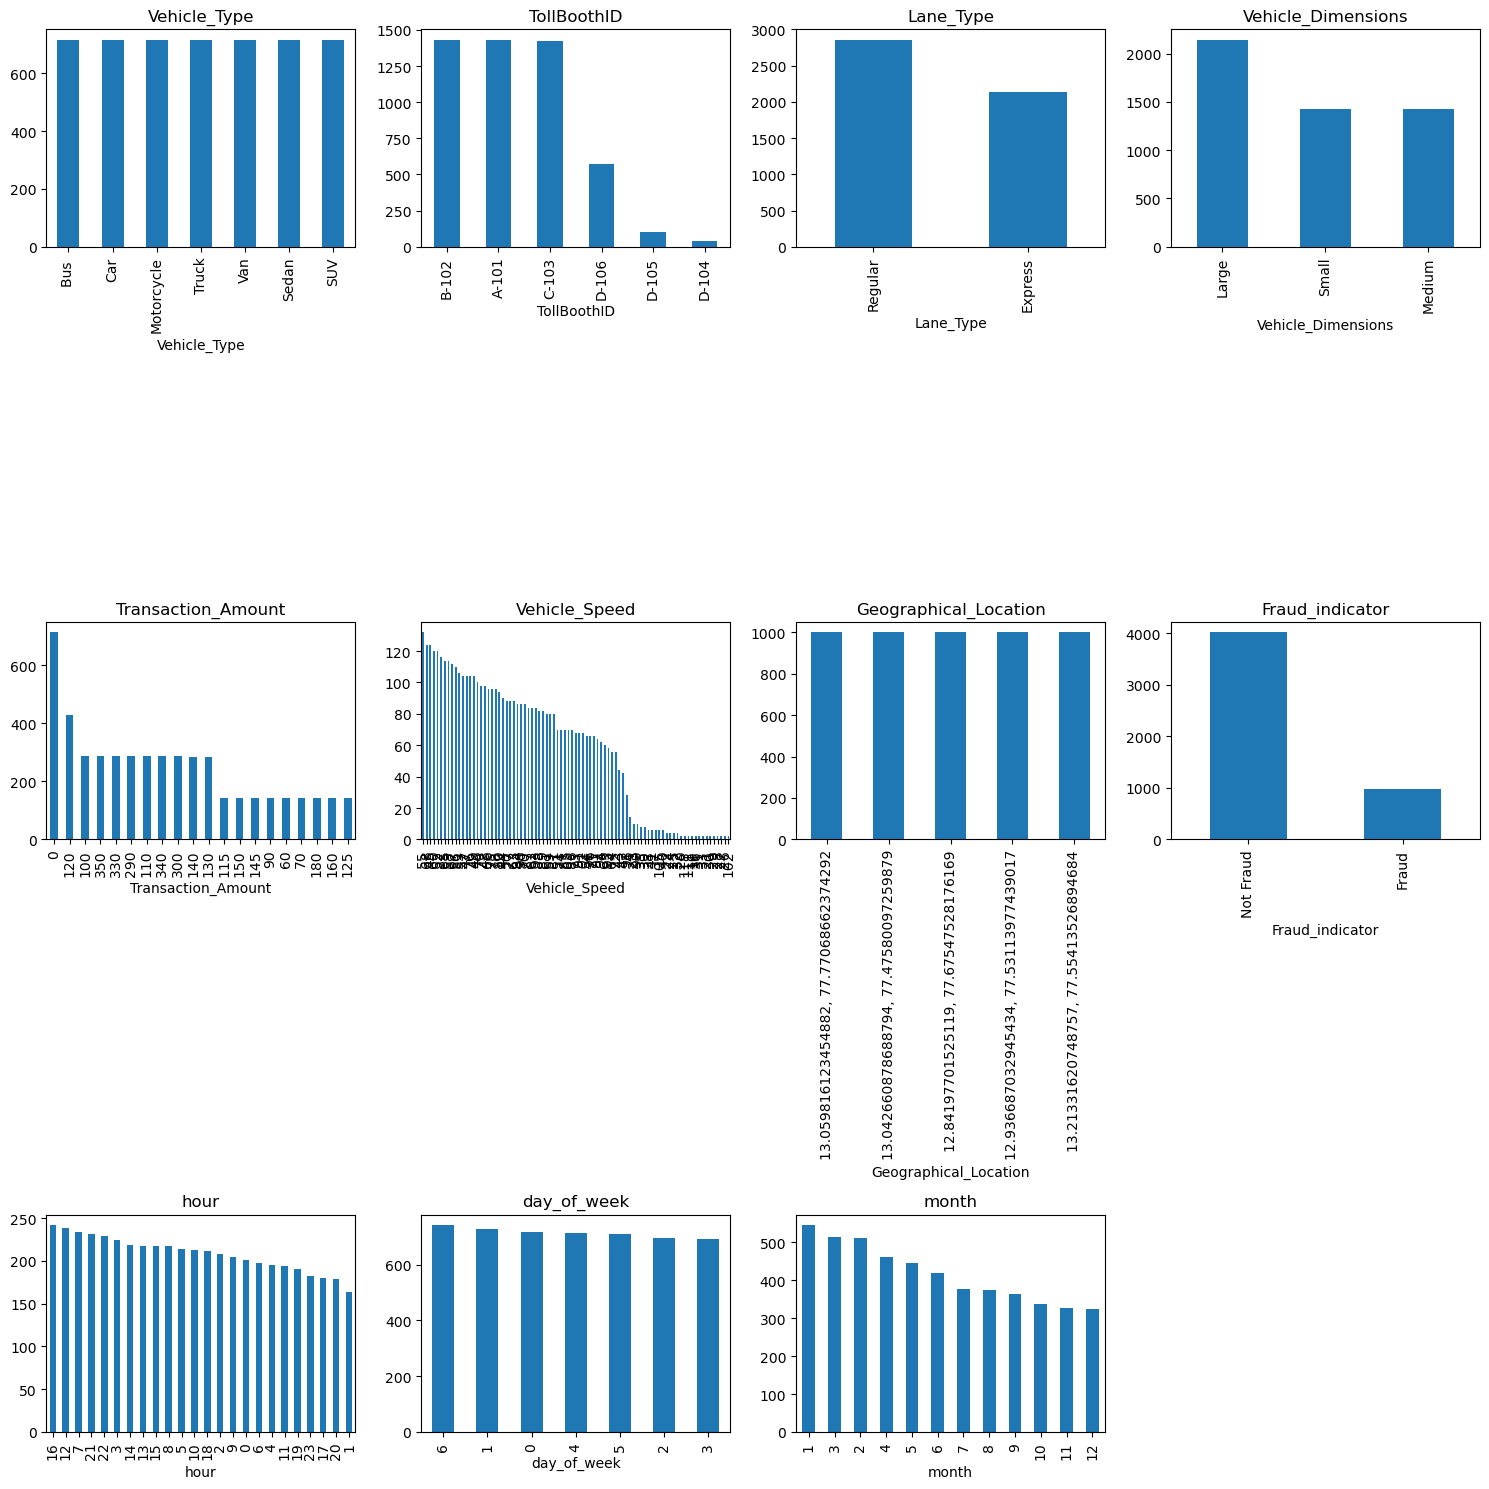

In [3]:
# Dropping features
df.drop(["Transaction_ID", "FastagID", "Timestamp", "Vehicle_Plate_Number"], axis=1, inplace=True)

categorical_features = ["Vehicle_Type", "TollBoothID", "Lane_Type", "Vehicle_Dimensions", "Transaction_Amount",
                        "Vehicle_Speed", "Geographical_Location", "Fraud_indicator", "hour", "day_of_week", "month"]
numeric_features = ["Amount_paid"]


# Calculate the number of rows and columns needed for the subplots
num_features = len(categorical_features)
num_cols = min(4, num_features)  # Maximum 4 plots per row
num_rows = -(-num_features // num_cols)  # Ceiling division to ensure enough rows

print("Categorical Column Distribution:")
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))  # Adjust figsize based on num_rows

for ax, col in zip(axs.flat, categorical_features):
    df[col].value_counts().plot(kind="bar", ax=ax, title=col)

# Hide empty subplots
for ax in axs.flat[num_features:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


RELATIONSHIP BETWEEN THE LABEL AND EACH FEATURE:
 


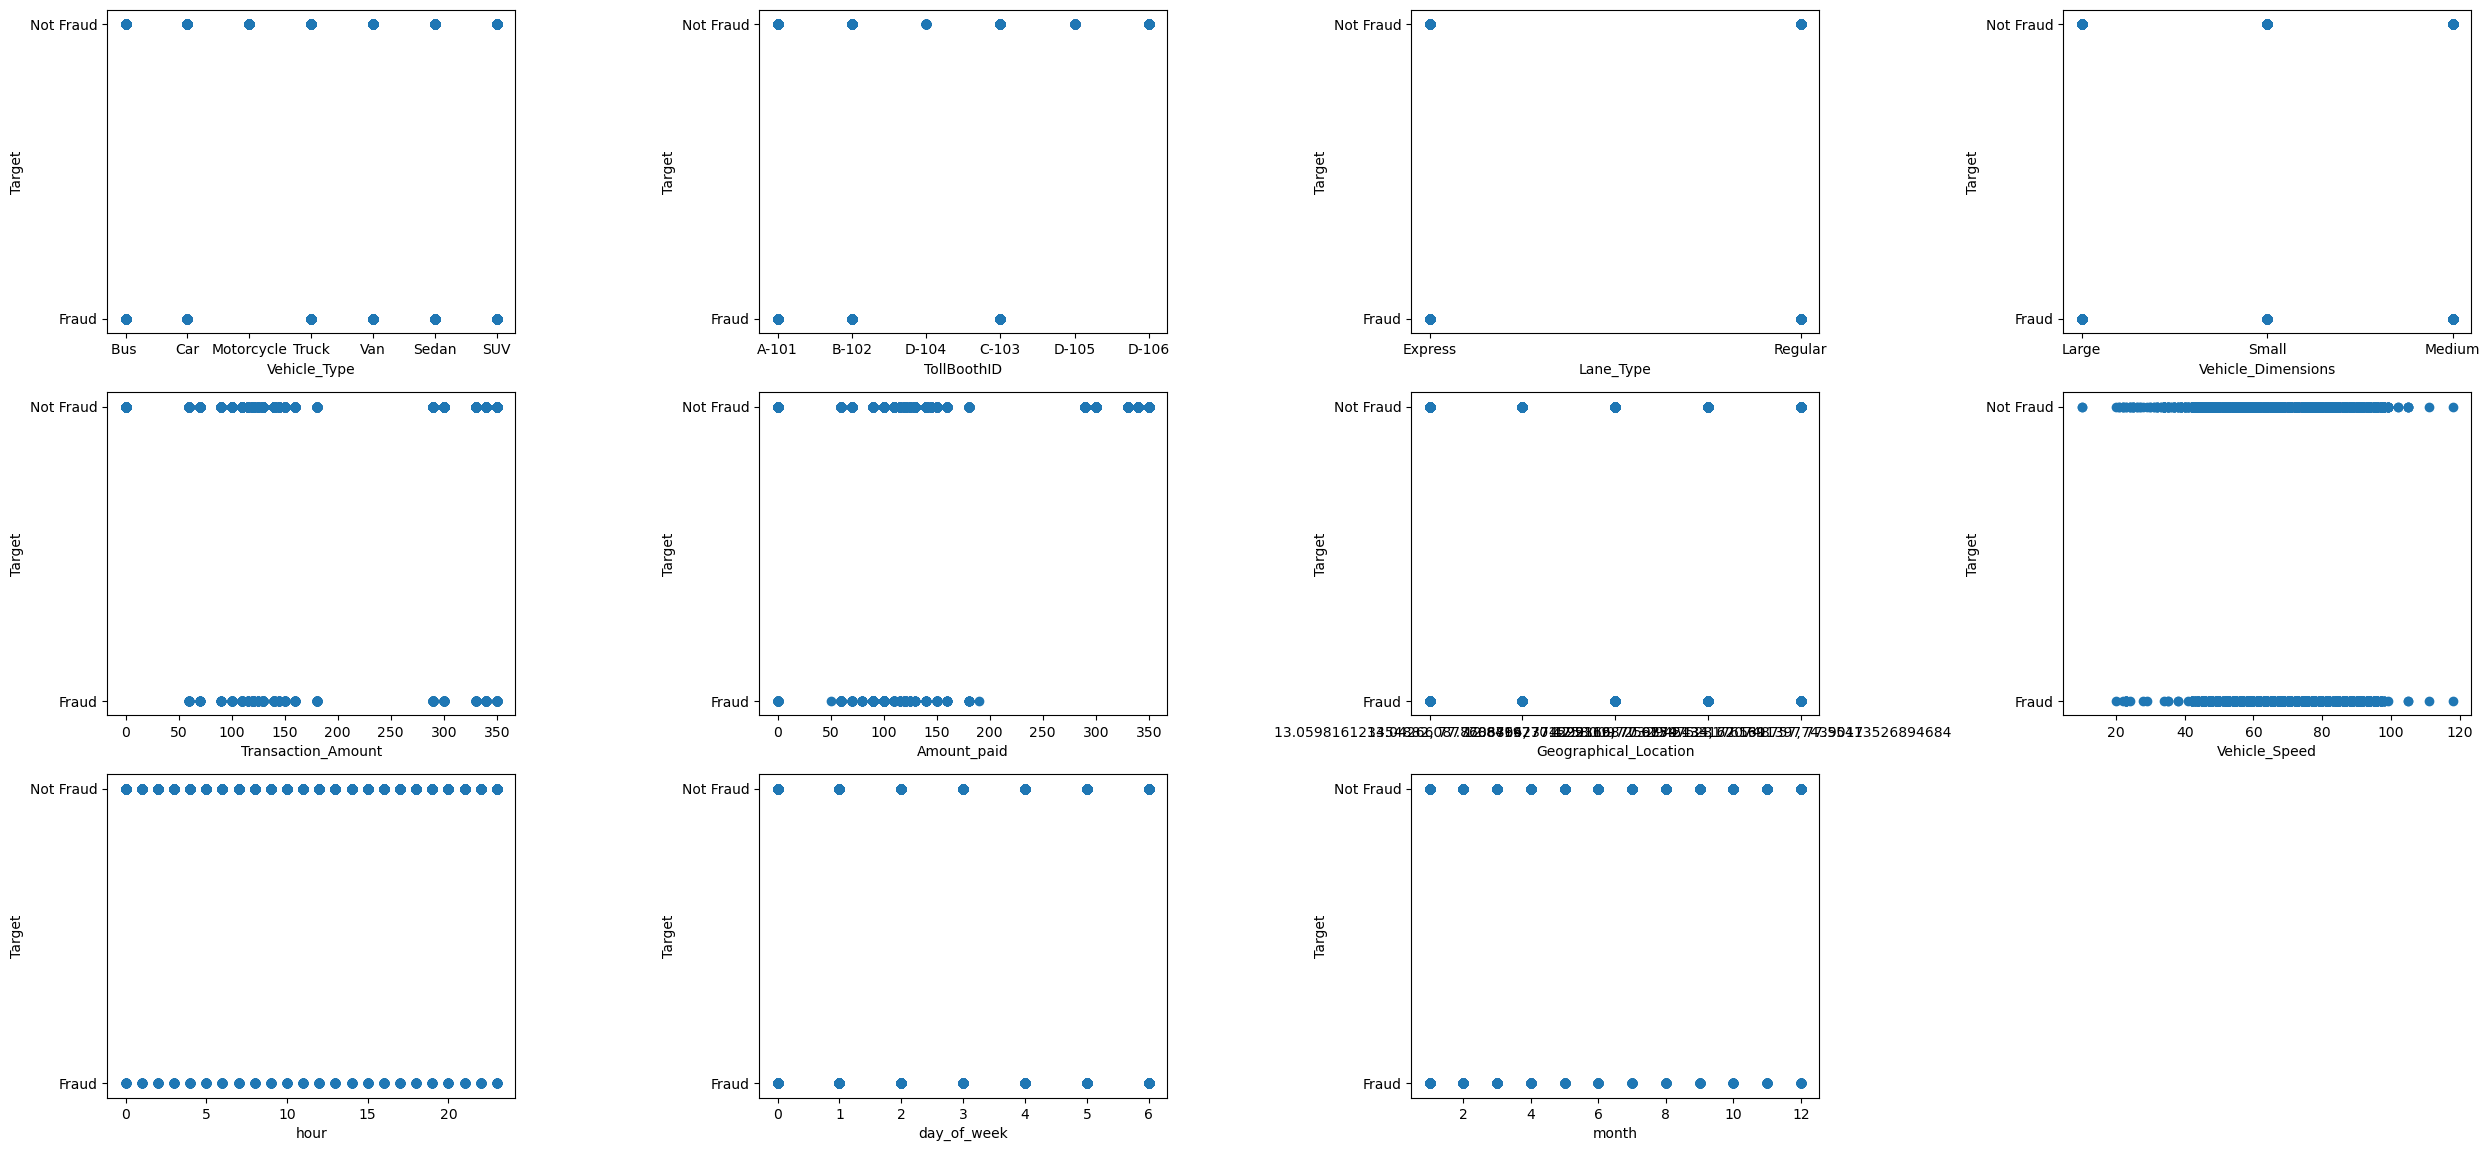

In [4]:
# Diving into features and label
X = df.drop("Fraud_indicator", axis=1)
y = df["Fraud_indicator"]


# Checking relationship between the label and each feature
print("RELATIONSHIP BETWEEN THE LABEL AND EACH FEATURE:")
print(" ")

fig, axs = plt.subplots(4, 4, figsize=(25, 15))  # Adjusting figsize to accommodate all plots
axs = axs.flatten()  # Flattening the array of axes for easy iteration

for i, col in enumerate(X.columns):
    axs[i].scatter(x=X[col], y=y)
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Target')  # Assuming 'Target' is what y represents

# Hide any unused subplots if X.columns has fewer than 16 columns
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [5]:
# Encoding categorical features with label encoder
def convert_to_numeric(df, categorical_features):
    # Initialize a dictionary to store mapping values
    mapping_values = {}

    # Initialize the LabelEncoder
    le = LabelEncoder()

    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature])
        mapping_values[feature] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    return df, mapping_values

df, mapping_values = convert_to_numeric(df, categorical_features)

# Print the mapping values for each encoded column
for feature, mapping in mapping_values.items():
    print(f"{feature} Mapping:")
    print(mapping)
    print()

Vehicle_Type Mapping:
{'Bus ': 0, 'Car': 1, 'Motorcycle': 2, 'SUV': 3, 'Sedan': 4, 'Truck': 5, 'Van': 6}

TollBoothID Mapping:
{'A-101': 0, 'B-102': 1, 'C-103': 2, 'D-104': 3, 'D-105': 4, 'D-106': 5}

Lane_Type Mapping:
{'Express': 0, 'Regular': 1}

Vehicle_Dimensions Mapping:
{'Large': 0, 'Medium': 1, 'Small': 2}

Transaction_Amount Mapping:
{0: 0, 60: 1, 70: 2, 90: 3, 100: 4, 110: 5, 115: 6, 120: 7, 125: 8, 130: 9, 140: 10, 145: 11, 150: 12, 160: 13, 180: 14, 290: 15, 300: 16, 330: 17, 340: 18, 350: 19}

Vehicle_Speed Mapping:
{10: 0, 20: 1, 21: 2, 22: 3, 23: 4, 24: 5, 25: 6, 26: 7, 27: 8, 28: 9, 29: 10, 30: 11, 31: 12, 32: 13, 33: 14, 34: 15, 35: 16, 36: 17, 37: 18, 38: 19, 39: 20, 40: 21, 41: 22, 42: 23, 43: 24, 44: 25, 45: 26, 46: 27, 47: 28, 48: 29, 49: 30, 50: 31, 51: 32, 52: 33, 53: 34, 54: 35, 55: 36, 56: 37, 57: 38, 58: 39, 59: 40, 60: 41, 61: 42, 62: 43, 63: 44, 64: 45, 65: 46, 66: 47, 67: 48, 68: 49, 69: 50, 70: 51, 71: 52, 72: 53, 73: 54, 74: 55, 75: 56, 76: 57, 77: 58, 78

## 2. Feature Engineering:
- Identify and engineer relevant features that contribute to fraud detection accuracy.

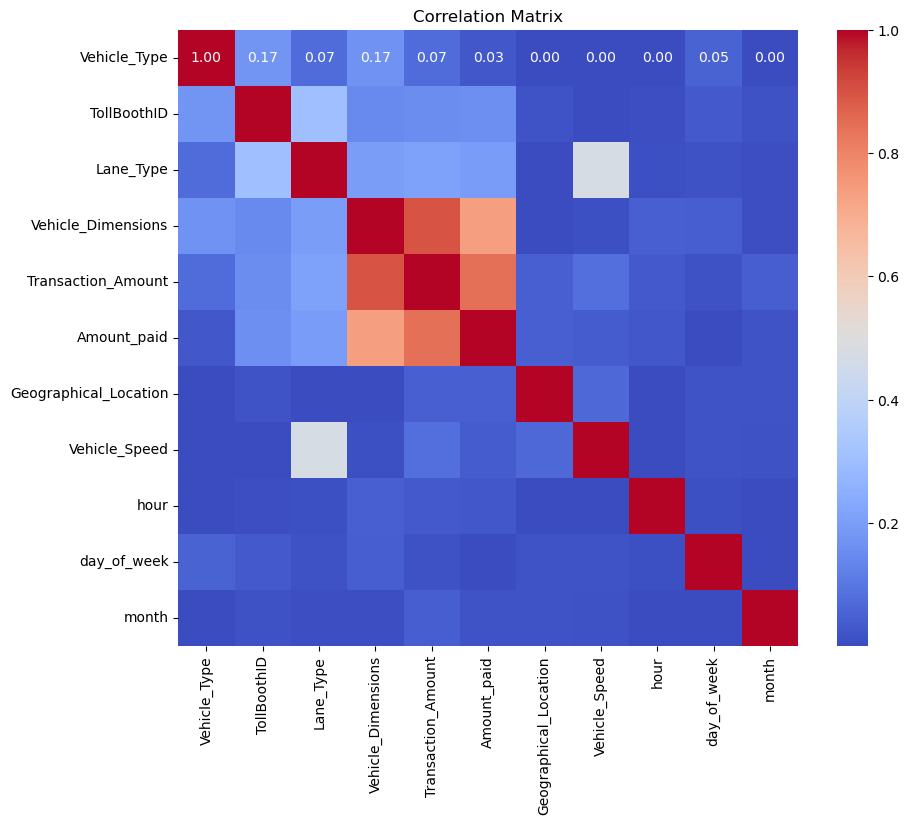

In [6]:
X = df.drop("Fraud_indicator", axis=1)
y = df["Fraud_indicator"]

# Heatmap of the correlation matrix
corr = X.corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# selecting upper Triangle of Correlation matrix
def drop_features(X):
    corr = X.corr().abs()
    
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    # Find features with correlation greater than the threshold
    threshold = 0.9
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop feature with high correlation
    X = X.drop(columns=to_drop)
    return X

X = drop_features(X)


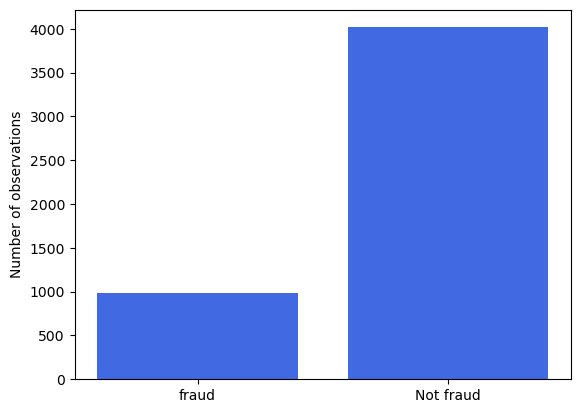

In [7]:
# Separate minority and majority classes
fraud = df[df['Fraud_indicator']==0]
not_fraud = df[df['Fraud_indicator']==1]
# Get all possible labels
labels = df['Fraud_indicator'].unique()
heights = [len(fraud),len(not_fraud)]
plt.bar(labels,heights,color='royalblue')
plt.xticks(labels,['fraud','Not fraud'])
plt.ylabel("Number of observations")
plt.show()

Resampled:


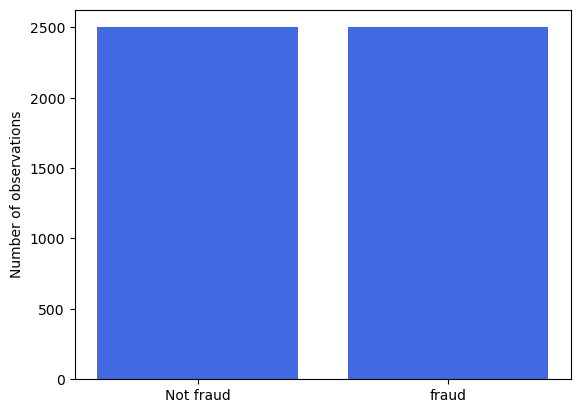

In [8]:
# Downsample majority
class_size = 2500
not_fraud_downsampled = resample(not_fraud,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=class_size, # match number in class size which is half the len of the most occured
                          random_state=42) # reproducible results
# Upsampling the minority
fraud_upsampled = resample(fraud,
                          replace=True, 
                          n_samples=class_size, # match number in minority class
                          random_state=42) # reproducible results

# Combine downsampled majority class with minority class
sampled = pd.concat([not_fraud_downsampled,fraud_upsampled])
sampled["Fraud_indicator"].value_counts()

print("Resampled:")
# Separate minority and majority classes
fraud = sampled[sampled['Fraud_indicator']==0]
not_fraud = sampled[sampled['Fraud_indicator']==1]
# Get all possible labels
labels = sampled['Fraud_indicator'].unique()
heights = [len(fraud),len(not_fraud)]
plt.bar(labels,heights,color='royalblue')
plt.xticks(labels,['fraud','Not fraud'])
plt.ylabel("Number of observations")
plt.show()

## 3. Model Development:
- Build a machine learning classification model to predict and detect Fastag transaction fraud.
- Evaluate and fine-tune model performance using appropriate metrics.

In [9]:
# Check new class counts
X = sampled.drop("Fraud_indicator", axis=1)
y = sampled["Fraud_indicator"]

# Splitting into train test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=.2,
                                                   random_state=42)

In [10]:

np.random.seed(42)
# Building models
model = {
    "Logistic Regression" : LogisticRegression(),
    "K Neighbors" : KNeighborsClassifier(),
    "Linera SVM" : SVC(kernel="linear", C=0.025),
    "RBF SVM" : SVC(gamma=2, C=1),
    "Decision Tree" : DecisionTreeClassifier(max_depth=5,min_samples_leaf=2),
    "Random Forest" : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Ada Boost": AdaBoostClassifier(n_estimators=40)
    
}

classification_model_performance_metrics(model)



Fitting Logistic Regression model...
Predicting...
Scoring...
Fitting K Neighbors model...
Predicting...
Scoring...
Fitting Linera SVM model...
Predicting...
Scoring...
Fitting RBF SVM model...
Predicting...
Scoring...
Fitting Decision Tree model...
Predicting...
Scoring...
Fitting Random Forest model...
Predicting...
Scoring...
Fitting Ada Boost model...
Predicting...
Scoring...
All done!


,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score,Train Time
Classifier,,,,,,,,,
Logistic Regression,0.92675,0.9655,0.896056,0.929483,0.931,0.964,0.904315,0.933204,0.115420
K Neighbors,0.96150,0.9580,0.964753,0.961365,0.929,0.940,0.919765,0.929773,0.021241
Linera SVM,0.93100,0.9770,0.894689,0.934034,0.935,0.976,0.902033,0.937560,1.145311
RBF SVM,1.00000,1.0000,1.000000,1.000000,0.935,1.000,0.884956,0.938967,2.941708
Decision Tree,0.93400,1.0000,0.883392,0.938086,0.929,1.000,0.875657,0.933707,0.010274
Random Forest,0.84800,0.8340,0.858025,0.845842,0.817,0.790,0.835095,0.811922,0.053170
Ada Boost,0.95900,0.9815,0.939234,0.959902,0.958,0.970,0.947266,0.958498,0.281270


In [11]:
final_model = AdaBoostClassifier(n_estimators=40)
final_model.fit(X_train, y_train)

# saving the model
import pickle
filename = "Fraud_prediction.sav"
pickle.dump(final_model, open(filename, "wb"))
print("Model saved!")

# Load model

load_model = pickle.load(open(filename, "rb"))
print("Model Loaded!")


Model saved!
Model Loaded!


## 4. Real-time Fraud Detection:
- Explore the feasibility of implementing the model for real-time Fastag fraud detection.


In [12]:
new_data = pd.DataFrame({"Vehicle_Type": "Car", "TollBoothID": "A-101", "Lane_Type": "Express", "Vehicle_Dimensions": "Small",
                         "Transaction_Amount":70, "Amount_paid":70, "Geographical_Location": "12.936687032945434, 77.53113977439017",
                        "Vehicle_Speed":75, "hour":15, "day_of_week":4, "month":1}, index=[0])


new_data["Vehicle_Type"] = new_data["Vehicle_Type"].map({'Bus ': 0, 'Car': 1, 'Motorcycle': 2, 'SUV': 3, 'Sedan': 4, 'Truck': 5, 'Van': 6})
new_data["TollBoothID"] = new_data["TollBoothID"].map({'A-101': 0, 'B-102': 1, 'C-103': 2, 'D-104': 3, 'D-105': 4, 'D-106': 5})
new_data["Lane_Type"] = new_data["Lane_Type"].map({'Express': 0, 'Regular': 1})
new_data["Vehicle_Dimensions"] = new_data["Vehicle_Dimensions"].map({'Large': 0, 'Medium': 1, 'Small': 2})
new_data["Transaction_Amount"] = new_data["Transaction_Amount"].map({0: 0, 60: 1, 70: 2, 90: 3, 100: 4, 110: 5, 115: 6, 120: 7, 125: 8,
                                                                     130: 9, 140: 10, 145: 11, 150: 12, 160: 13, 180: 14, 290: 15, 300: 16,
                                                                     330: 17, 340: 18, 350: 19})
new_data["Geographical_Location"] = new_data["Geographical_Location"].map({'12.84197701525119, 77.67547528176169': 0,
                                                                           '12.936687032945434, 77.53113977439017': 1,
                                                                           '13.042660878688794, 77.47580097259879': 2,
                                                                           '13.059816123454882, 77.77068662374292': 3,
                                                                           '13.21331620748757, 77.55413526894684': 4})
new_data["Vehicle_Speed"] = new_data["Vehicle_Speed"].map({10: 0, 20: 1, 21: 2, 22: 3, 23: 4, 24: 5, 25: 6, 26: 7, 27: 8, 28: 9, 29: 10, 30: 11,
                                                           31: 12, 32: 13, 33: 14, 34: 15, 35: 16, 36: 17, 37: 18, 38: 19, 39: 20, 40: 21, 41: 22,
                                                           42: 23, 43: 24, 44: 25, 45: 26, 46: 27, 47: 28, 48: 29, 49: 30, 50: 31, 51: 32, 52: 33,
                                                           53: 34, 54: 35, 55: 36, 56: 37, 57: 38, 58: 39, 59: 40, 60: 41, 61: 42, 62: 43, 63: 44,
                                                           64: 45, 65: 46, 66: 47, 67: 48, 68: 49, 69: 50, 70: 51, 71: 52, 72: 53, 73: 54, 74: 55,
                                                           75: 56, 76: 57, 77: 58, 78: 59, 79: 60, 80: 61, 81: 62, 82: 63, 83: 64, 84: 65, 85: 66,
                                                           86: 67, 87: 68, 88: 69, 89: 70, 90: 71, 91: 72, 92: 73, 93: 74, 94: 75, 95: 76, 96: 77,
                                                           97: 78, 98: 79, 99: 80, 102: 81, 105: 82, 111: 83, 118: 84})

new_data["hour"] = new_data["hour"].map({0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14,
                                         15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23})
new_data["day_of_week"] = new_data["day_of_week"].map({0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6})
new_data["month"] = new_data["month"].map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11})


load_model.predict(new_data)

array([1])

## 5. Explanatory Analysis:
- Provide insights into the factors contributing to fraudulent transactions.

In [13]:
feature_importance = pd.DataFrame((load_model.feature_importances_ * 100), index=X.columns, columns=["Feature Importances (%)"])
feature_importance = feature_importance.sort_values(by="Feature Importances (%)", ascending=False)
feature_importance

,Feature Importances (%)
Amount_paid,45.0
Transaction_Amount,32.5
hour,7.5
Vehicle_Speed,5.0
TollBoothID,2.5
Lane_Type,2.5
Geographical_Location,2.5
month,2.5
Vehicle_Type,0.0
Vehicle_Dimensions,0.0
